In [2]:
# default_exp bbox_east_training

# EAST

In [2]:
#export
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
from torch.autograd import Variable
from fastai.callbacks import LossMetrics

In [3]:
#export
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
from ocr.core import save_inference, load_inference, plot
from ocr.textbox_dataset_sroie2019 import get_filename2bboxes_dict, create_df

In [6]:
#export
class east_config:
    HEIGHT = 1024
    WIDTH = 384
    out_shape = (4,4) # 4 times smaller than input
    
east_config.input_shape = (east_config.HEIGHT, east_config.WIDTH)

In [20]:
output_shape_dx = listify(east_config.out_shape)
assert output_shape_dx == listify((4,4)) or output_shape_dx == listify((8,8))

### Prep

In [6]:
filenames_df = create_df()
filenames_df.head()

image_path  valid    dataset
0  ../data/sroie2019/train_img/X51006327978.jpg  False  sroie2019
1  ../data/sroie2019/train_img/X51006619550.jpg  False  sroie2019
2  ../data/sroie2019/train_img/X51005361883.jpg  False  sroie2019
3  ../data/sroie2019/train_img/X51008123451.jpg  False  sroie2019
4  ../data/sroie2019/train_img/X51005361900.jpg  False  sroie2019

In [7]:
filename2bbs = get_filename2bboxes_dict() # bboxes, labels = this[filename]

### Databunch

In [8]:
#export
class ObjectCategoryProcessor(MultiCategoryProcessor):
    "`PreProcessor` for labelled bounding boxes."
    def __init__(self, ds:ItemList, pad_idx:int=0):
        super().__init__(ds)
        self.pad_idx = pad_idx
        self.state_attrs.append('pad_idx')

    def process(self, ds:ItemList):
        ds.pad_idx = self.pad_idx
        super().process(ds)

    def process_one(self,item): return [item[0], [self.c2i.get(o,None) for o in item[1]]]

    def generate_classes(self, items):
        "Generate classes from unique `items` and add `background`."
        classes = super().generate_classes([o[1] for o in items])
        classes = ['background'] + list(classes)
        return classes
    
def _get_size(xs,i):
    size = xs.sizes.get(i,None)
    if size is None:
        # Image hasn't been accessed yet, so we don't know its size
        _ = xs[i]
        size = xs.sizes[i]
    return size

In [9]:
#export
class ObjectCategoryList(MultiCategoryList):
    "`ItemList` for labelled bounding boxes."
    _processor = ObjectCategoryProcessor

    def get(self, i):
        return ImageBBox.create(*_get_size(self.x,i), *self.items[i], classes=self.classes, pad_idx=self.pad_idx)

    def analyze_pred(self, pred): return pred

    def reconstruct(self, t, x):
        (bboxes, labels, *_) = t # CHANGED
        if len((labels - self.pad_idx).nonzero()) == 0: return
        i = (labels - self.pad_idx).nonzero().min()
        bboxes,labels = bboxes[i:],labels[i:]
        return ImageBBox.create(*x.size, bboxes, labels=labels, classes=self.classes, scale=False)

In [10]:
#export
class ObjectItemList(ImageList):
    "`ItemList` suitable for object detection."
    _label_cls,_square_show_res = ObjectCategoryList,False

In [11]:
#export
def bb_pad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]:
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    if isinstance(samples[0][1], int): return data_collate(samples)
    max_len = max([len(s[1].data[1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i, (image, bbox) in enumerate(samples):
        bbs, lbls = bbox.data
        imgs.append(image.data[None])
        assert len(bbs) == len(lbls)
        
        if bbs.nelement() != 0:
            bboxes[i,-len(bbs):] = bbs
            labels[i,-len(lbls):] = tensor(lbls)
    return torch.cat(imgs,0), (bboxes,labels)

In [12]:
#export
def _gaussian_blur(x, size:uniform_int):
    blurred = cv2.blur(image2np(x), (size,size)) # np.arr
#     blurred = cv2.GaussianBlur(image2np(x), (size,size), 0)
    return tensor(blurred).permute(2,0,1)

def gaussian_blur(size, p=1.0):
    return RandTransform(tfm=TfmPixel(_gaussian_blur), kwargs={'size':size}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [13]:
train_transforms = [
    rand_crop(padding_mode='zeros'),
    rotate(degrees=(-3, 3), p=0.3),
    symmetric_warp(magnitude=(-0.07, 0.07), p=0.7),
#     dihedral_affine(p=0.2),
    rand_zoom(scale=(0.9,2.), p=0.4),
    brightness(change=(0.3, 0.7), p=0.5),
    contrast(scale=(0.7,1.3), p=0.5),
#     textify(),
    gaussian_blur(size=(1, 3), p=0.3)
]

valid_transforms = [
#     crop_pad()
]

In [14]:
# ratio = 1.3846 # h/w
# HEIGHT = 1080
# WIDTH = int(HEIGHT/ratio)

In [15]:
def path2bb(path):
    fn = path.split(os.path.sep)[-1]
    return filename2bbs[fn]

In [16]:
data = (ObjectItemList.from_df(filenames_df, path='.', cols='image_path')
                      .split_from_df('valid')
                      .label_from_func(path2bb)
                      .transform((train_transforms, valid_transforms), tfm_y=True, size=(east_config.HEIGHT,east_config.WIDTH))
                      .databunch(bs=4, collate_fn=bb_pad_collate)
                      .normalize(imagenet_stats)
       )
data

ImageDataBunch;

Train: LabelList (703 items)
x: ObjectItemList
Image (3, 1024, 384),Image (3, 1024, 384),Image (3, 1024, 384),Image (3, 1024, 384),Image (3, 1024, 384)
y: ObjectCategoryList
ImageBBox (1024, 384),ImageBBox (1024, 384),ImageBBox (1024, 384),ImageBBox (1024, 384),ImageBBox (1024, 384)
Path: .;

Valid: LabelList (344 items)
x: ObjectItemList
Image (3, 1024, 384),Image (3, 1024, 384),Image (3, 1024, 384),Image (3, 1024, 384),Image (3, 1024, 384)
y: ObjectCategoryList
ImageBBox (1024, 384),ImageBBox (1024, 384),ImageBBox (1024, 384),ImageBBox (1024, 384),ImageBBox (1024, 384)
Path: .;

Test: None

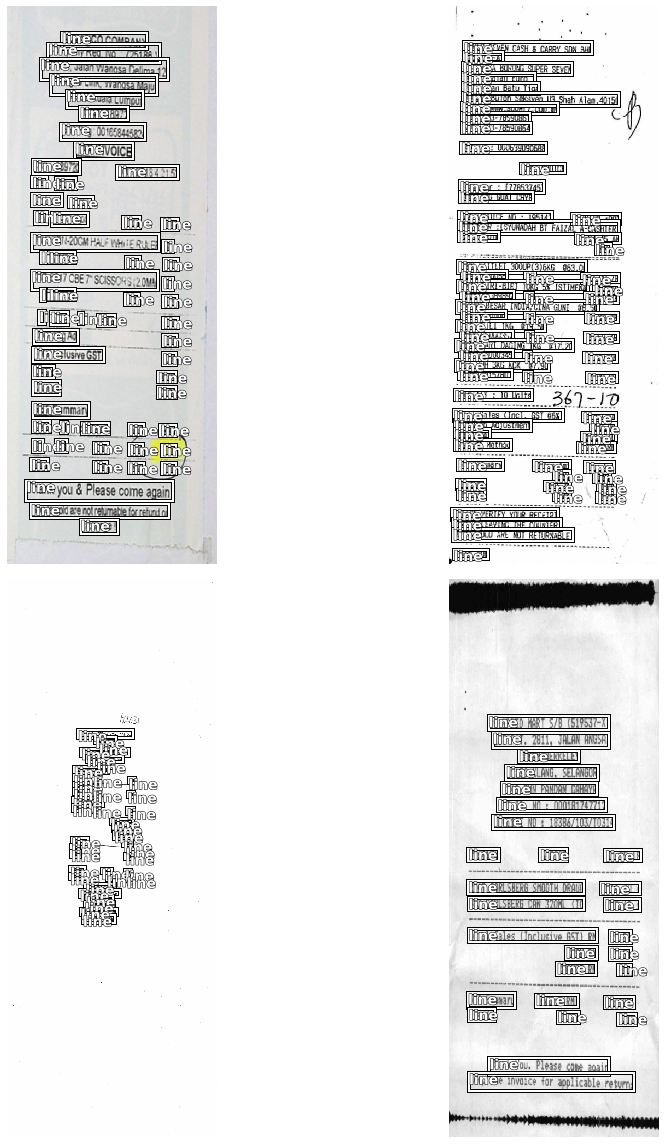

In [17]:
data.show_batch(2, imgsize=8)

### Model

In [12]:
#export
class UnetTypeConcat(nn.Module):
    def __init__(self, unpool_layer, conv_layer):
        super().__init__()
        # conv_layer: has to ...
        # unpool_layer: has to increase [h,w] -> [hx2, wx2]
        self.unpool = unpool_layer
        self.conv = conv_layer
        
    def forward(self, e, d): # e/d - encoder/decoder output
        '''
        @param:  :encoder output
        @param:  :decoder output
        '''
        o = self.unpool(d)
        o = torch.cat((o, e), 1)
        return self.conv(o)

In [17]:
#export

# To work w/ ResNet18 change conv_layers in unet_concat:
# 3072 -> 768
# 640 -> 256
# 320 ->128
# (also pixelshuffle)

class EastModel(nn.Module):
    def __init__( self, pixelshuffle=True, conv_out=(listify(east_config.out_shape) == listify((8,8))) ):
        super().__init__()
        self.conv_out = conv_out

        self.resnet = models.resnet50(pretrained=True)
        
        if pixelshuffle:
            unpool1 = nn.Sequential(nn.PixelShuffle(2), nn.Conv2d(512, 512*4, kernel_size=1))
            unpool2 = nn.Sequential(nn.PixelShuffle(2), nn.Conv2d(32,  32*4,  kernel_size=1))
            unpool3 = nn.Sequential(nn.PixelShuffle(2), nn.Conv2d(16,  16*4,  kernel_size=1))
        else:
            unpool1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            unpool2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            unpool3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        self.unet_block1 = UnetTypeConcat(unpool1, conv_layer(ni=3072, nf=128, ks=1))
        self.unet_block2 = UnetTypeConcat(unpool2, conv_layer(ni=640,  nf=64,  ks=1))
        self.unet_block3 = UnetTypeConcat(unpool3, conv_layer(ni=320,  nf=64,  ks=1))
        
        self.conv_bonus1 = conv_layer(ni=128,  nf=128, ks=3)
        self.conv_bonus2 = conv_layer(ni=64,   nf=64,  ks=3)
        self.conv1 = conv_layer(ni=64,   nf=32,  ks=3)
        self.conv2 = conv_layer(ni=32,   nf=32,  ks=3)
        self.conv_score = conv_layer(ni=32,   nf=1,   ks=1, norm_type=None, use_activ=False)
        self.conv_geo   = conv_layer(ni=32,   nf=4,   ks=1, norm_type=None, use_activ=False)
#         self.conv10 = conv_layer(ni=32,  nf=1,   ks=1, norm_type=None, use_activ=False)
        
        if self.conv_out:
            self.conv_out = conv_layer(ni=32, nf=32, ks=3, stride=2, norm_type=None)

    def forward(self, x):
        f = []
        for layer in list(self.resnet.children())[:-1]:
            x = layer(x)
            if type(layer) == torch.nn.Sequential: f.append(x)
        
        # [b,128,h/16,w/16] = unet_block1([b,1024,h/16,w/16], [b,2048,h/32,w/32])
        o = self.unet_block1(f[2], f[3])
        o = self.conv_bonus1(o)
        # [b,64,h/8,w/8] = unet_block1([b,512,h/8,w/8], [b,128,h/16,w/16])
        o = self.unet_block2(f[1], o)
        o = self.conv_bonus2(o)
        # [b,64,h/4,w/4] = unet_block1([b,256,h/4,w/4], [b,64,h/8,w/8])
        o = self.unet_block3(f[0], o)

        o = self.conv1(o)  # [b,32,h/4,w/4]
        o = self.conv2(o)  # [b,32,h/4,w/4]
        
        if self.conv_out: o = self.conv_out(o) # [b,32,h/2,w/2]
        
        score = self.conv_score(o) # [b,1,h/4,w/4]
        geo_map = self.conv_geo(o) # [b,4,h/4,w/4]
        
        score = nn.Sigmoid()(score)
        geo_map = nn.Sigmoid()(geo_map)*2
        
#         angle_map = self.conv10(g)
#         angle_map = self.sigmoid(angle_map)
#         angle_map = (angle_map - 0.5) * math.pi / 2
#         geo = torch.cat((geo_map, angle_map), 1)  # bs 5 w/4 w/4
        geo = geo_map
        
        return score, geo

In [18]:
score, geo = EastModel()(torch.zeros(2,3,east_config.HEIGHT,east_config.WIDTH))
score.shape, geo.shape

(torch.Size([2, 1, 256, 96]), torch.Size([2, 4, 256, 96]))

### Obj. Detection

In [21]:
#export
# tlbr - top, left, bottom, right
# bb - bounding box
tlbr2hw = lambda bbs: bbs[:,2:] - bbs[:,:2] # [N,4] -> [N,2]

def intersection(bbs1, bbs2, normalize=False):
    ''' Calculates intersection area of bounding boxes
    @param: [N1,4]  :N1 tlbr coordinates
    @param: [N2,4]  :N2 tlbr coordinates
    @return [N1,N2] :area sizes for each coord combination
    '''
    N1, N2 = bbs1.size(0), bbs2.size(0)
    bbs1, bbs2 = bbs1.unsqueeze(1).expand(N1,N2,4), bbs2.unsqueeze(0).expand(N1,N2,4)
    intersection_tl_corner = torch.max(bbs1[...,:2], bbs2[...,:2]) # [N1,N2,2]
    intersection_br_corner = torch.min(bbs1[...,2:], bbs2[...,2:]) # [N1,N2,2]
    sizes = torch.clamp(intersection_br_corner - intersection_tl_corner, min=0) # [N1,N2,2]
    
    if normalize:
        hw = tlbr2hw(bbs1[:,0,:]) # [N1,2]
        sizes[...,:] /= hw.unsqueeze(1) # [N1,N2,2] * [N1,1,2]
    
    return sizes[...,0] * sizes[...,1] # [N1,N2]

In [22]:
intersection( tensor([[.1,.1,.4,.4]]), tensor([[.2,.2,.5,.5]]) ) # should be area of tldr(2,2,4,4) -> 4

tensor([[0.0400]])

In [23]:
#export
normalized_intersection = partial(intersection, normalize=True)

In [24]:
normalized_intersection( tensor([[.1,.1,.4,.4]]), tensor([[.2,.2,.5,.5]]) )

tensor([[0.4444]])

In [25]:
#export
def tlbr2cthw(bbs):
    ''' Convert top/left bottom/right format `boxes` to center/size corners
    @param: [N,4] :tlbr coordinates
    @return [N,4] :cthw coordinates
    '''
    center = (bbs[:,:2] + bbs[:,2:])/2 # [N,2]
    sizes = bbs[:,2:] - bbs[:,:2] # [N,2]
    return torch.cat([center, sizes], 1) # 

In [26]:
#export
tlbr2hw = lambda bbs: bbs[:,2:] - bbs[:,:2] # [N,4] -> [N,2]
hw2area = lambda hw: hw[:,0] * hw[:,1] # [N,2] -> [N]

def IoU(bbs1, bbs2):
    ''' Calculates intersection area of bounding boxes
    @param: [N1,4]  :N1 tlbr coordinates
    @param: [N2,4]  :N2 tlbr coordinates
    @return [N1,N2] :area sizes for each coord combination
    '''
    inter = intersection(bbs1, bbs2) # [N1,N2]
    hw1, hw2 = tlbr2hw(bbs1), tlbr2hw(bbs2) # [N,2]
    bbs1_areas = hw2area(hw1).unsqueeze(1) # [N1,1]
    bbs2_areas = hw2area(hw2).unsqueeze(0) # [1,N2]
    union = bbs1_areas + bbs2_areas - inter
    return inter/(union+1e-8)

In [27]:
IoU( tensor([[1,1,4,4]]), tensor([[1,1,4,4], [1,1,5,5]]) )

tensor([[1.0000, 0.5625]])

In [28]:
#export
# a bit problematic w/ int input and by_iou=False
def match_anchors(anchors, targets, match_thr=0.01, bg_thr=0.01, by_iou=False):
    ''' Match `anchors` to targets. -1 is match to background, -2 is ignore
    @param: [N1,4]  :N1 tlbr coordinates
    @param: [N2,4]  :N2 tlbr coordinates
    @param: int     :if this < IoU -> this match is a match (int index of match in targets)
    @param: int     :if this > IoU -> this match is a background (int -1)
    @param: bool    :to
    @return [N1]    :every match from anchors to targets index (if doesnt exist it is -2/-1)
    '''
    f = IoU if by_iou else normalized_intersection
    ious = f(anchors, targets) # [N1,N2]
#     print(anchors)
#     print(targets)
#     print('ious: \n', ious)
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
#     matches = torch.zeros(anchors.size(0)).zero_().long() - 2
    
    if ious.shape[1] == 0:
        print('ious.shape[1] == 0')
        return matches
    
    iou, idxs = torch.max(ious, dim=1) # [N1]
    matches[iou < bg_thr] = -1
    matches[iou > match_thr] = idxs[iou > match_thr]
    
    return matches

In [29]:
# a bit problematic w/ int input and by_iou=False
match_anchors( tensor([[.1,1,4,4], [.1,1,5,5]]), tensor([[.1,1,5,5], [.1,1,3,3], [.1,1,4,4]]) )

tensor([2, 0])

In [30]:
#export
def create_grid(size):
    ''' Creates a x,y grid of size `size`, coords start from -1 to 1
    @param: tuple(H,W) :tuple of 2 ints H(height), W(width)
    @return [H,W,4]    :tlbr coords for each (h,w) cell 
    '''
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 4)
    
    # not precise, but good enough
    linear_points_left = torch.linspace(0, 1-1/W, W) # [0, 1]
    linear_points_right = linear_points_left + 1/W
    linear_points_top = torch.linspace(0, 1-1/H, H) # [0, 1]
    linear_points_btm = linear_points_top + 1/H
    
    grid[:, :, 0] = linear_points_top.unsqueeze(1).expand(H,W)
    grid[:, :, 1] = linear_points_left.unsqueeze(0).expand(H,W)
    grid[:, :, 2] = linear_points_btm.unsqueeze(1).expand(H,W)
    grid[:, :, 3] = linear_points_right.unsqueeze(0).expand(H,W)
    return grid*2-1

In [31]:
grid = create_grid((4,10))
for i in range(5,10):
    print(grid[0,i])

tensor([-1.0000e+00, -5.9605e-08, -5.0000e-01,  2.0000e-01])
tensor([-1.0000,  0.2000, -0.5000,  0.4000])
tensor([-1.0000,  0.4000, -0.5000,  0.6000])
tensor([-1.0000,  0.6000, -0.5000,  0.8000])
tensor([-1.0000,  0.8000, -0.5000,  1.0000])


In [32]:
#export
anchors = create_grid((east_config.HEIGHT//4, east_config.WIDTH//4)).view(-1,4)

In [33]:
#export
def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def _draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

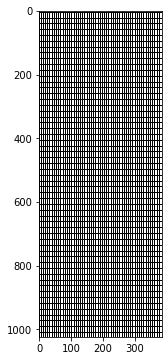

In [34]:
anchors = create_grid((56,56)).view(-1,4)

fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(image2np(data.valid_ds[0][0].data))

anchors = tlbr2cthw(anchors)

for i, bbox in enumerate(anchors):
    bb = bbox.numpy()
    x = (bb[0] + 1) * east_config.WIDTH / 2 
    y = (bb[1] + 1) * east_config.HEIGHT / 2 
    w = bb[2] * east_config.WIDTH / 2
    h = bb[3] * east_config.HEIGHT / 2
    
    rect = [x,y,w,h]
    _draw_rect(ax,rect)

In [35]:
x, y = data.one_batch(DatasetType.Train, True, True)

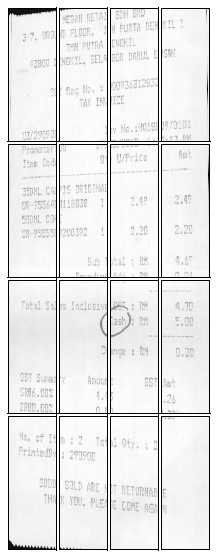

In [36]:
anchors = create_grid((4,4)).view(-1,4)

for image, bboxes, labels in zip(x, y[0], y[1]):
    image = Image(image.float().clamp(min=0, max=1))
    imageBB = ImageBBox.create(*image.size, tensor(anchors), scale=False)
    image.show(y=imageBB, figsize=(10,10))
    break

In [37]:
#export
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

def show_anchors_on_images(data, anchors, figsize=(15,15)):
    all_boxes = []
    all_labels = []
    x, y = data.one_batch(DatasetType.Train, True, True)
    for image, bboxes, labels in zip(x, y[0], y[1]):
        image = Image(image.float().clamp(min=0, max=1))

        # 0=not found; 1=found; found 2=anchor
        processed_boxes = []
        processed_boxes_gt = []
        processed_boxes_bg = []
        processed_labels = []
        processed_labels_gt = []
        a = 0
        bgs = torch.zeros(len(anchors), dtype=bool) + 1
        for gt_box in bboxes[labels > 0]:
            matches = match_anchors(anchors, gt_box[None, :])
            non_bg = matches >= 0
            a += non_bg.sum()
#             print('1)', non_bg.sum(), (matches >= -1).sum(), (matches >= -2).sum())
            if non_bg.sum() != 0:
                processed_boxes_gt.append(to_np(gt_box))
                processed_labels_gt.append(2)
                for bb in anchors[non_bg]:
                    processed_boxes.append(to_np(bb))
                    processed_labels.append(3)
                bgs[non_bg] = 0
            else:
                processed_boxes.append(to_np(gt_box))
                processed_labels.append(0)
                val, idx = torch.max(IoU(anchors, gt_box[None, :]), 0)
                best_fitting_anchor = anchors[idx][0]
                processed_boxes.append(to_np(best_fitting_anchor))
                processed_labels.append(1)
            if a > 500:
                break
        all_boxes.extend(processed_boxes)
        all_labels.extend(processed_labels)

        processed_boxes = np.array(processed_boxes)
        processed_labels = np.array(processed_labels)
        
#         print('2)', np.unique(processed_labels, return_counts=True))

        _, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
        ax[0].set_title("Matched Anchors")
        ax[1].set_title("Actual GT")
        ax[2].set_title("BG Anchors")
        
        # Anchors
        imageBB = ImageBBox.create(*image.size, tensor(processed_boxes[processed_labels > 1]),
#                                    labels=processed_labels[processed_labels > 1],
                                   classes=["", "", "", ""], scale=False)
#                                        classes=["", "", "Match", "Anchor"], scale=False)

        image.show(ax=ax[0], y=imageBB)
        
        # Actual
        imageBB = ImageBBox.create(*image.size, tensor(processed_boxes_gt),
#                                    labels=[processed_labels[0]],
                                   classes=["", "", "", ""], scale=False)
#                                        classes=["", "", "Match", "Anchor"], scale=False)
        image.show(ax=ax[1], y=imageBB)
        
        # BG Anchors
        imageBB = ImageBBox.create(*image.size, tensor(anchors[bgs == 1][1000:2000]),
                                   classes=["", "", "", ""], scale=False)
        image.show(ax=ax[2], y=imageBB)
        break

#     return np.array(all_boxes), np.array(all_labels)

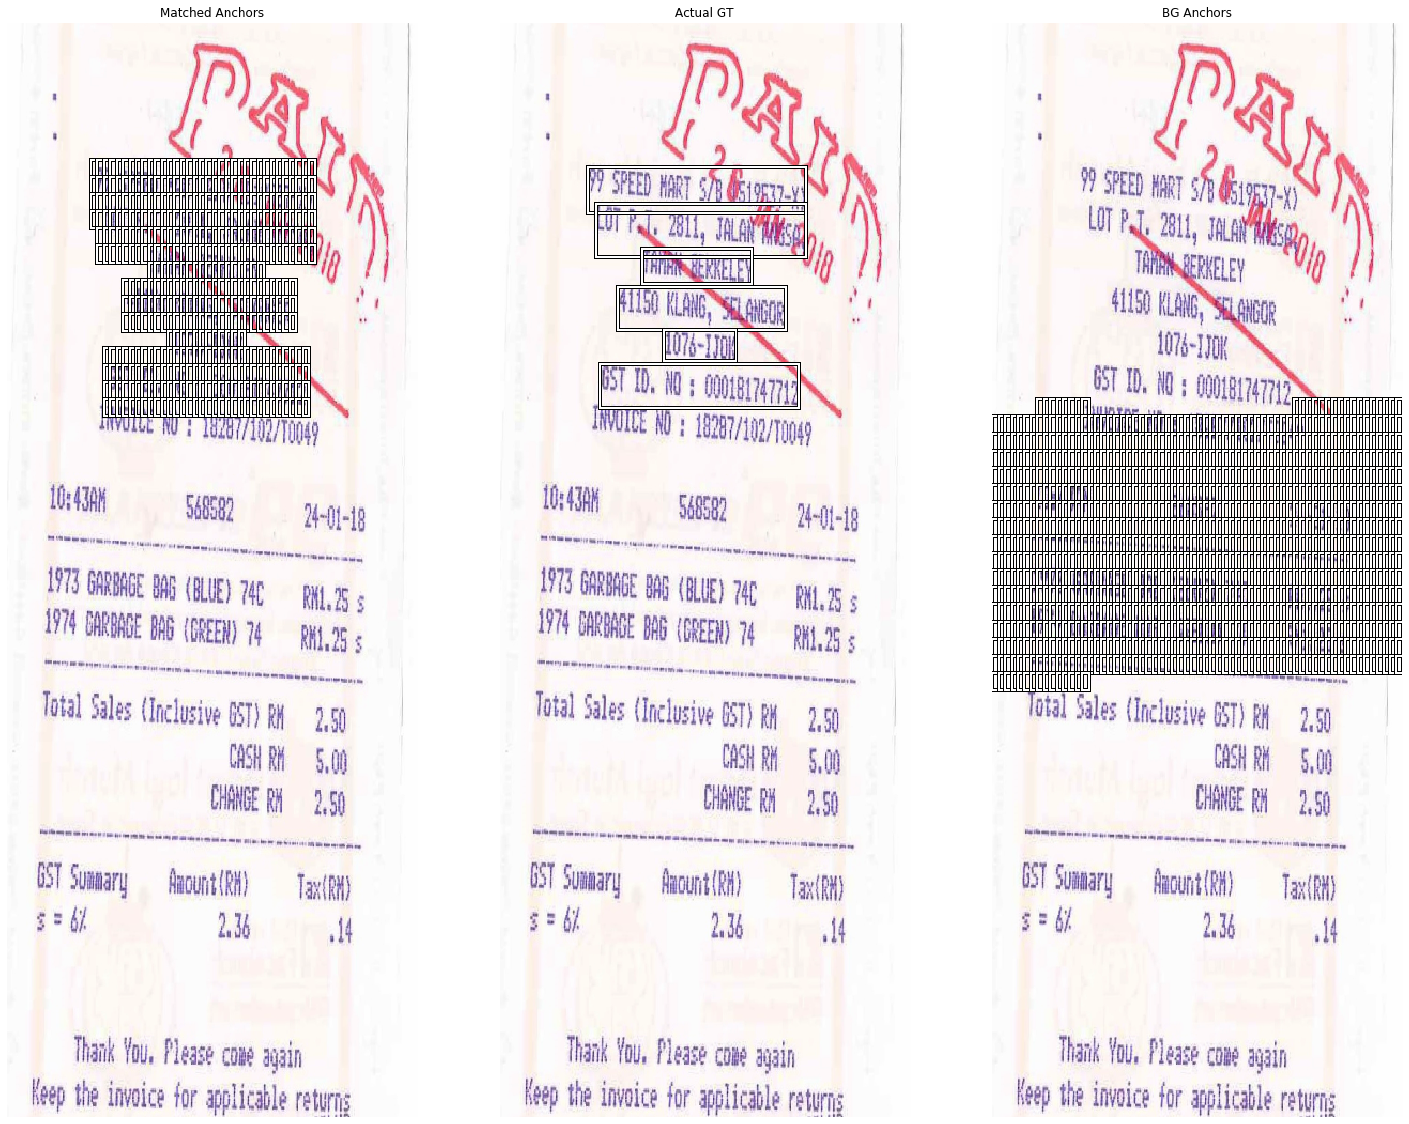

In [38]:
anchors = create_grid((64,64)).view(-1,4)
show_anchors_on_images(data, anchors, figsize=(25,25))

In [39]:
#export
def tlbr2cthw(boxes): # [N,4] -> [N,4]
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)


def bbox_to_target(bboxes, anchors):
    ''' Return the target of the model on `anchors` for the `bboxes`
    @param: [N,4] :N tlbr coordinates (true bboxes), (bboxes must match anchors)
    @param: [N,4] :N tlbr coordinates (selected anchors)
    @return [N,4] :distance of how much bboxes are from anchors
    '''
    bboxes, anchors = tlbr2cthw(bboxes), tlbr2cthw(anchors)
    t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:]
    t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8)
    return torch.cat([t_centers, t_sizes], -1)#.div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))

In [40]:
bbox_to_target(tensor([[.2,.2,.4,.4], [.1,.1,.5,.5], [.1,.1,.5,.5]]), tensor([[.2,.2,.5,.5], [.1,.1,.3,.3], [.1,.1,.5,.5]]) )

tensor([[-0.1667, -0.1667, -0.4055, -0.4055],
        [ 0.5000,  0.5000,  0.6931,  0.6931],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])

In [41]:
#export
# tlbr to center coords
tlbr2cc = lambda boxes: (boxes[:,:2] + boxes[:,2:])/2 # [N,4] -> [N,2]

# Override
def bbox_to_target(bboxes, anchors):
    ''' Return the target of the model on `anchors` for the `bboxes`
    @param: [N,4] :N tlbr coordinates (true bboxes), (bboxes must match anchors)
    @param: [N,4] :N tlbr coordinates (selected anchors)
    @return [N,4] :distance of how much bboxes are from anchors
    '''
    a_centers = tlbr2cc(anchors)
    return torch.cat([a_centers - bboxes[...,:2], bboxes[...,2:] - a_centers], -1) # .div_(bboxes.new_tensor([[0.1, 0.1, 0.1, 0.1]]))

In [42]:
bbox_to_target(tensor([[.2,.2,.4,.4], [.1,.1,.5,.5], [.1,.1,.5,.5]]), tensor([[.2,.2,.5,.5], [.1,.1,.3,.3], [.1,.1,.5,.5]]) )

tensor([[0.1500, 0.1500, 0.0500, 0.0500],
        [0.1000, 0.1000, 0.3000, 0.3000],
        [0.2000, 0.2000, 0.2000, 0.2000]])

In [43]:
#export
def prepare_bboxes(anchors, bbox_true, bbox_pred):
    ''' Return the target of the model on `anchors` for the `bboxes`
    @param: [N1,4] :tlbr coordinates (all anchors), N1 = H x W
    @param: [N2,4] :tlbr coordinates (true bboxes)
    @param: [N1,4] :tlbr coordinates (nn output bboxes)
    @return ([N3,4], [N3,4], [N3,4]) or None :bbox_true, bbox_pred, matches (for caching)
    '''
    matches = match_anchors(anchors, bbox_true) # [N3, 4]
    non_bg = matches >= 0 # [N3, 4] (non background)

    if non_bg.sum() == 0:
#         print('non_bg.sum() == 0') # creates a bit of spam (0-2 per epoch)
        return None, None, None

    bbox_pred = bbox_pred[non_bg] # [N3,4]
    bbox_true = bbox_true[matches[non_bg]] # [N3,4] (matches return bbox_true indexes)
    anchors = anchors[non_bg] # [N3,4]
    return bbox_to_target(bbox_true, anchors), bbox_pred, matches

In [44]:
#export
def prepare_labels(y_true, y_pred, matches):
    ''' Prepare the probabilities of target and prediction of the model
    @param: [N1]           :
    @param: [H/4 x W/4, 1] :
    @param: [H/4 x W/4]    :
    @return [N2], [N2, 1]  :
    '''
    if matches is None: matches = torch.zeros_like(y_pred).squeeze()
    non_ignore = matches >= -1
    if non_ignore.sum() != matches.size(0):
        print('non_ignore.sum() != matches.size(0)', non_ignore.sum(), matches.size(0))
    
    target = y_true.new_zeros(len(matches)).float()
    non_bg = matches >= 0
    target[non_bg] = 1
    
    return target[non_ignore][:, None], y_pred[non_ignore]

In [45]:
#export
class BBLossMetrics(LossMetrics):
    def on_batch_end(self, last_target, train, **kwargs):
        "Update the metrics if not `train`"
        if train: return
        bs = last_target[0].size(0) # CHANGED
        for name in self.names:
            self.metrics[name] += bs * self.learn.loss_func.metrics[name].detach().cpu()
        self.nums += bs

In [46]:
#export
def target_to_bbox(output, anchors):
#     output.mul_(output.new_tensor([[0.1, 0.1, 0.1, 0.1]]))
    a_centers = tlbr2cc(anchors)
    return torch.cat([a_centers - output[...,:2], a_centers + output[...,2:]], -1)

In [47]:
#export
def nms(boxes, scores, threshold=0.2):
    ''' non maximum suppression
    @param: [N,4]
    @param: [N]
    @return [N1]
    '''
    sorted_idx = scores.argsort(descending=True) # [N]
    boxes, scores = boxes[sorted_idx], scores[sorted_idx]
    to_keep, indexes = [], torch.LongTensor(range(len(scores))) # [], [N]
    while len(scores) > 0:
        # put in highest scored index
        to_keep.append(sorted_idx[indexes[0]])
        # calculate IoU of highest_scored_box vs all_boxes
        ious = IoU(boxes, boxes[0].view(1,4)).squeeze() # [N]
        other_boxes = ious <= threshold # [N] (not the same boxes)
        if other_boxes.sum() == 0: break
        if other_boxes.sum() == len(boxes):
            if len(indexes) < 3: break
            boxes, scores, indexes = boxes[1:], scores[1:], indexes[1:]
            continue
        boxes, scores, indexes = boxes[other_boxes], scores[other_boxes], indexes[other_boxes]
    
    return LongTensor(to_keep)

In [48]:
#export
def _unpad(bbox_true, y_true, pad_idx=0):
    ''' [N_max,4], [N_max] -> [N1,4], [N1] '''
    i = torch.min(torch.nonzero(y_true - pad_idx)) if sum(y_true)>0 else 0
    return bbox_true[i:], y_true[i:] + pad_idx

def check_overlap(i_true, _list, is_overlaping):
    for i_pred in _list:
        if is_overlaping[i_pred, i_true]:
            return i_pred
    return None

def calc_precision_recall(bbox_pred, bbox_true, iou_thresh=0.5):
    ''' [P,4], [T,4] (Preds, Trues)'''
    num_preds, num_trues = len(bbox_pred), len(bbox_true)

    ious = IoU(bbox_pred, bbox_true)
    is_overlaping = ious > iou_thresh
    
    correct = 0
    pred_idxes =list(range(len(bbox_pred)))
    for i_true in range(len(bbox_true)):
        i_overlap = check_overlap(i_true, pred_idxes, is_overlaping)
        if i_overlap is not None:
            pred_idxes.remove(i_overlap)
            correct += 1
            
    precision = correct / num_preds
    recall = correct / num_trues
    # print(precision, recall, correct, num_preds)
    return precision, recall

def F1(last_output, bbox_true_b, y_true_b, detect_thresh=0.8, iou_thresh=0.5, **kwargs):
    y_pred_b, bbox_pred_b = last_output
    if len(y_true_b) == 0: return tensor(0.)
    
    f1 = 0
    for y_pred, bbox_pred, y_true, bbox_true in zip(y_pred_b, bbox_pred_b, y_true_b, bbox_true_b):
        
        # 1.get true bbox
        bbox_true, y_true = _unpad(bbox_true, y_true) # [N1,4]

        # 2. get pred bbox
        bbox_pred = bbox_pred.permute(1,2,0).view(-1,4)
        y_pred = y_pred.view(-1,1)

        bbox_pred = target_to_bbox(bbox_pred, anchors.to(y_pred.device))
    #     bbox_pred = bbox_pred.to('cpu')

        detect_mask = y_pred.squeeze() > detect_thresh # [H x W]
        if detect_mask.sum() == 0:
#             print('iou_metric: detect_mask.sum() == 0') # (too much spam when network start learning)
            return tensor(0)

        keep_idxes = nms(bbox_pred[detect_mask], y_pred[detect_mask].view(-1), threshold=0.2)
        bbox_pred = bbox_pred[detect_mask][keep_idxes] # [N2,4]

        # 3. calc result
        precision, recall = calc_precision_recall(bbox_pred, bbox_true, iou_thresh=iou_thresh)
        if precision + recall < 0.001: f1 += 0.
        else: f1 += 2 * (precision * recall) / (precision + recall)
    return tensor(f1 / len(y_true_b))

In [49]:
def show_examples(learner, image_count=4, detect_thresh=0.95, show_bbox=True):
    img_batch, target_batch = learner.data.one_batch(DatasetType.Valid, False, False, False)

    prediction_batch = learner.model(img_batch[:image_count])
    class_pred_batch, bbox_pred_batch = prediction_batch[:2]

    bbox_gt_batch, class_gt_batch = target_batch[0][:image_count], target_batch[1][:image_count]
    
    for img, bbox_gt, class_gt, clas_pred, bbox_pred in list(zip(img_batch, bbox_gt_batch, class_gt_batch, class_pred_batch, bbox_pred_batch)):
        if hasattr(learner.data, 'stats'):
            img = Image(learner.data.denorm(img))
        else:
            img = Image(img)
        image = img

        bbox_pred = bbox_pred.permute(1,2,0).view(-1,4)
    #     print(bbox_pred)
        y_pred = clas_pred.view(-1,1)

        bbox_pred = target_to_bbox(bbox_pred, anchors.to(y_pred.device))
        bbox_pred = bbox_pred.to('cpu')

        detect_mask = y_pred.squeeze() > detect_thresh # [H x W]
        print('total found bbs:', detect_mask.sum())
        if detect_mask.sum() == 0: break

        _, ax = plt.subplots(nrows=1, ncols=3, figsize=(50,30))

        ax[2].set_title("Found Anchors")
        anchs = tensor(anchors[detect_mask])
        imageBB = ImageBBox.create(*image.size, anchs, scale=False)
        image.show(ax=ax[2], y=imageBB)
        
        if show_bbox:
            t = bbox_pred[detect_mask]

            keep_idxes = nms(t, y_pred[detect_mask].view(-1), threshold=0.2)
            preds = tensor(t[keep_idxes])
            print('after nms:', len(preds))

            ax[0].set_title("Corresponding anchors BBox")
            imageBB = ImageBBox.create(*image.size, preds, scale=False)
            image.show(ax=ax[0], y=imageBB)

        bbox_true, bbox_pred_2, matches = prepare_bboxes(anchors.to(y_pred.device), bbox_gt, bbox_pred)
        bbox_true = target_to_bbox(bbox_true.to('cpu'), anchors[matches >= 0].to('cpu'))

        ax[1].set_title("True targets")
        trues = tensor(bbox_true)
        imageBB = ImageBBox.create(*image.size, trues[::10], scale=False)
        image.show(ax=ax[1], y=imageBB)

In [50]:
#export
def iou_loss(y_pred_geo, y_true_geo, eps=1.0):
    '''
    @param: [N,4] :
    @param: [N,4] :
    '''
    # d1 -> top, d2->left, d3->bottom, d4->right
    d1_true, d2_true, d3_true, d4_true = torch.split(y_true_geo, 1, 1) # [N,1] x 4
    d1_pred, d2_pred, d3_pred, d4_pred = torch.split(y_pred_geo, 1, 1) # [N,1] x 4
    area_true = (d1_true + d3_true) * (d2_true + d4_true)
    area_pred = (d1_pred + d3_pred) * (d2_pred + d4_pred)
    inter_width = torch.min(d2_true, d2_pred) + torch.min(d4_true, d4_pred)
    inter_height = torch.min(d1_true, d1_pred) + torch.min(d3_true, d3_pred)
    area_intersect = inter_width * inter_height
    area_union = area_true + area_pred - area_intersect
    L_AABB = -torch.log((area_intersect + eps) / (area_union + eps))
    return L_AABB

def dice_loss(y_pred, y_true):
    inter = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) + 1e-5
    return 1. - (2 * inter / union)

In [51]:
#export
def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

class SigmaL1SmoothLoss(nn.Module):
    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()
    
class RetinaNetFocalLoss(nn.Module):
    def __init__(self, anchors: Collection[float], gamma=1.0, pad_idx=0, class_loss_weight=1.0):
        super().__init__()
        self.class_weight = class_loss_weight
        self.gamma, self.pad_idx = gamma, pad_idx
        self.anchors, self.metric_names = anchors, ['bbox_loss', 'class_loss']

    def _unpad(self, bbox_true, y_true):
        ''' [N_max,4], [N_max] -> [N1,4], [N1] '''
        i = torch.min(torch.nonzero(y_true - self.pad_idx)) if sum(y_true)>0 else 0
        return bbox_true[i:], y_true[i:] + self.pad_idx

    def _cls_loss(self, y_pred, y_true, matches):
        ''' [N,1], [N,1] '''
#         return dice_loss(y_pred, y_true)
#         return F.binary_cross_entropy(y_pred, y_true)
        
        # CE = -log(pt), where pt is prob of correct class
        CE = F.binary_cross_entropy(y_pred, y_true, reduction='none')
        pt = torch.exp(-CE)
        return torch.mean( (1-pt)**self.gamma * CE )
    
    def _reg_loss(self, bbox_pred, bbox_true, y_pred):
        loss = iou_loss(bbox_pred*256, torch.clamp(bbox_true, min=0)*256)
        weights = -torch.log( torch.clamp( 1-y_pred, min=1e-3, max=0.7) )
#         weights = y_pred + 0.3
        return torch.mean(loss * weights)

    def _one_loss(self, y_pred, bbox_pred, y_true, bbox_true):
        ''' [N,C], [N,4], [N_max], [N_max,4] -> float, float '''
        bbox_true, y_true = self._unpad(bbox_true, y_true) # [N1,4], [N1]
        bbox_true, bbox_pred, matches = prepare_bboxes(self.anchors, bbox_true, bbox_pred) # [N2,4], [N2,4]
        if matches is None or matches is None: return tensor(0.)
        y_true, y_pred = prepare_labels(y_true, y_pred, matches) # [N2], [N2]
        bb_loss = self._reg_loss(bbox_pred, bbox_true, y_pred[matches[matches >= 0]])
        y_loss = self._cls_loss(y_pred, y_true, matches)
        self.metrics += tensor([bb_loss, y_loss])
        return (1-self.class_weight) * bb_loss + self.class_weight * y_loss

    def forward(self, nn_output, bbox_true, y_true):
        y_pred, bbox_pred = nn_output
        '''
        @param: [B, 1, H/4, W/4] :probability for each h,w cell
        @param: [B, 4, H/4, W/4] :bboxes for each h,w cell
        @param: [B, N_max, 4]    :true bboxes
        @param: [B, N_max]       :true label (1/0)
        '''
        if bbox_true.device != self.anchors.device:
            self.anchors = self.anchors.to(y_pred.device)

        loss = torch.tensor(0, dtype=torch.float32).to(y_pred.device)
        self.metrics = tensor([0., 0.])
        for yp, bp, yt, bt in zip(y_pred, bbox_pred, y_true, bbox_true):
            loss += self._one_loss(yp.view(-1,1), bp.permute(1,2,0).view(-1,4), yt, bt)
        
        bs = y_true.size(0)
        self.metrics = dict(zip(self.metric_names, [m/bs for m in self.metrics]))
        return loss/bs

In [53]:
#export
class MSEloss(RetinaNetFocalLoss):
    def _reg_loss(self, bbox_pred, bbox_true, y_pred):
        return nn.MSELoss()(bbox_pred, bbox_true)
    
    def _one_loss(self, y_pred, bbox_pred, y_true, bbox_true):
        ''' [N,C], [N,4], [N_max], [N_max,4] -> float, float '''
        bbox_true, y_true = self._unpad(bbox_true, y_true) # [N1,4], [N1]
        bbox_true, bbox_pred, matches = prepare_bboxes(self.anchors, bbox_true, bbox_pred) # [N2,4], [N2,4]
        if matches is None or matches is None: return tensor(0.)
        y_true, y_pred = prepare_labels(y_true, y_pred, matches) # [N2], [N2]
        bb_loss = self._reg_loss(bbox_pred, bbox_true, y_pred[matches[matches >= 0]])
        return bb_loss

In [54]:
anchors = create_grid((east_config.HEIGHT//4, east_config.WIDTH//4)).view(-1,4)
model = EastModel()

In [55]:
#export
mse = MSEloss(anchors)
def MSE(last_output, bbox_true, y_true, **kwargs):
    return mse(last_output, bbox_true, y_true)

In [76]:
# # either load or create new learner
learner = load_inference('east_bbox_10x3')
learner.data = data

In [57]:
loss = RetinaNetFocalLoss(anchors, class_loss_weight=0.5)
learner = Learner(data, model, loss_func=loss, callback_fns=[ShowGraph, BBLossMetrics], metrics=[MSE,F1])

In [58]:
# learner.summary()

In [59]:
list_layers = [
    learner.model.resnet,
    learner.model.unet_block1,
#     learner.model.conv_bonus1,
    learner.model.unet_block2,
#     learner.model.conv_bonus2,
    learner.model.unet_block3,
    learner.model.conv1,
    learner.model.conv2,
    learner.model.conv_score,
    learner.model.conv_geo
]

learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')

Learner split in 8 groups


In [60]:
learner.freeze_to(1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.75E-01


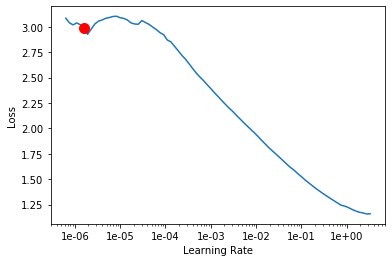

In [61]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

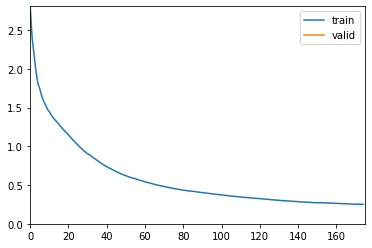

In [62]:
learner.fit_one_cycle(1, 1e-2)

total found bbs: tensor(3949, device='cuda:0')
after nms: 60


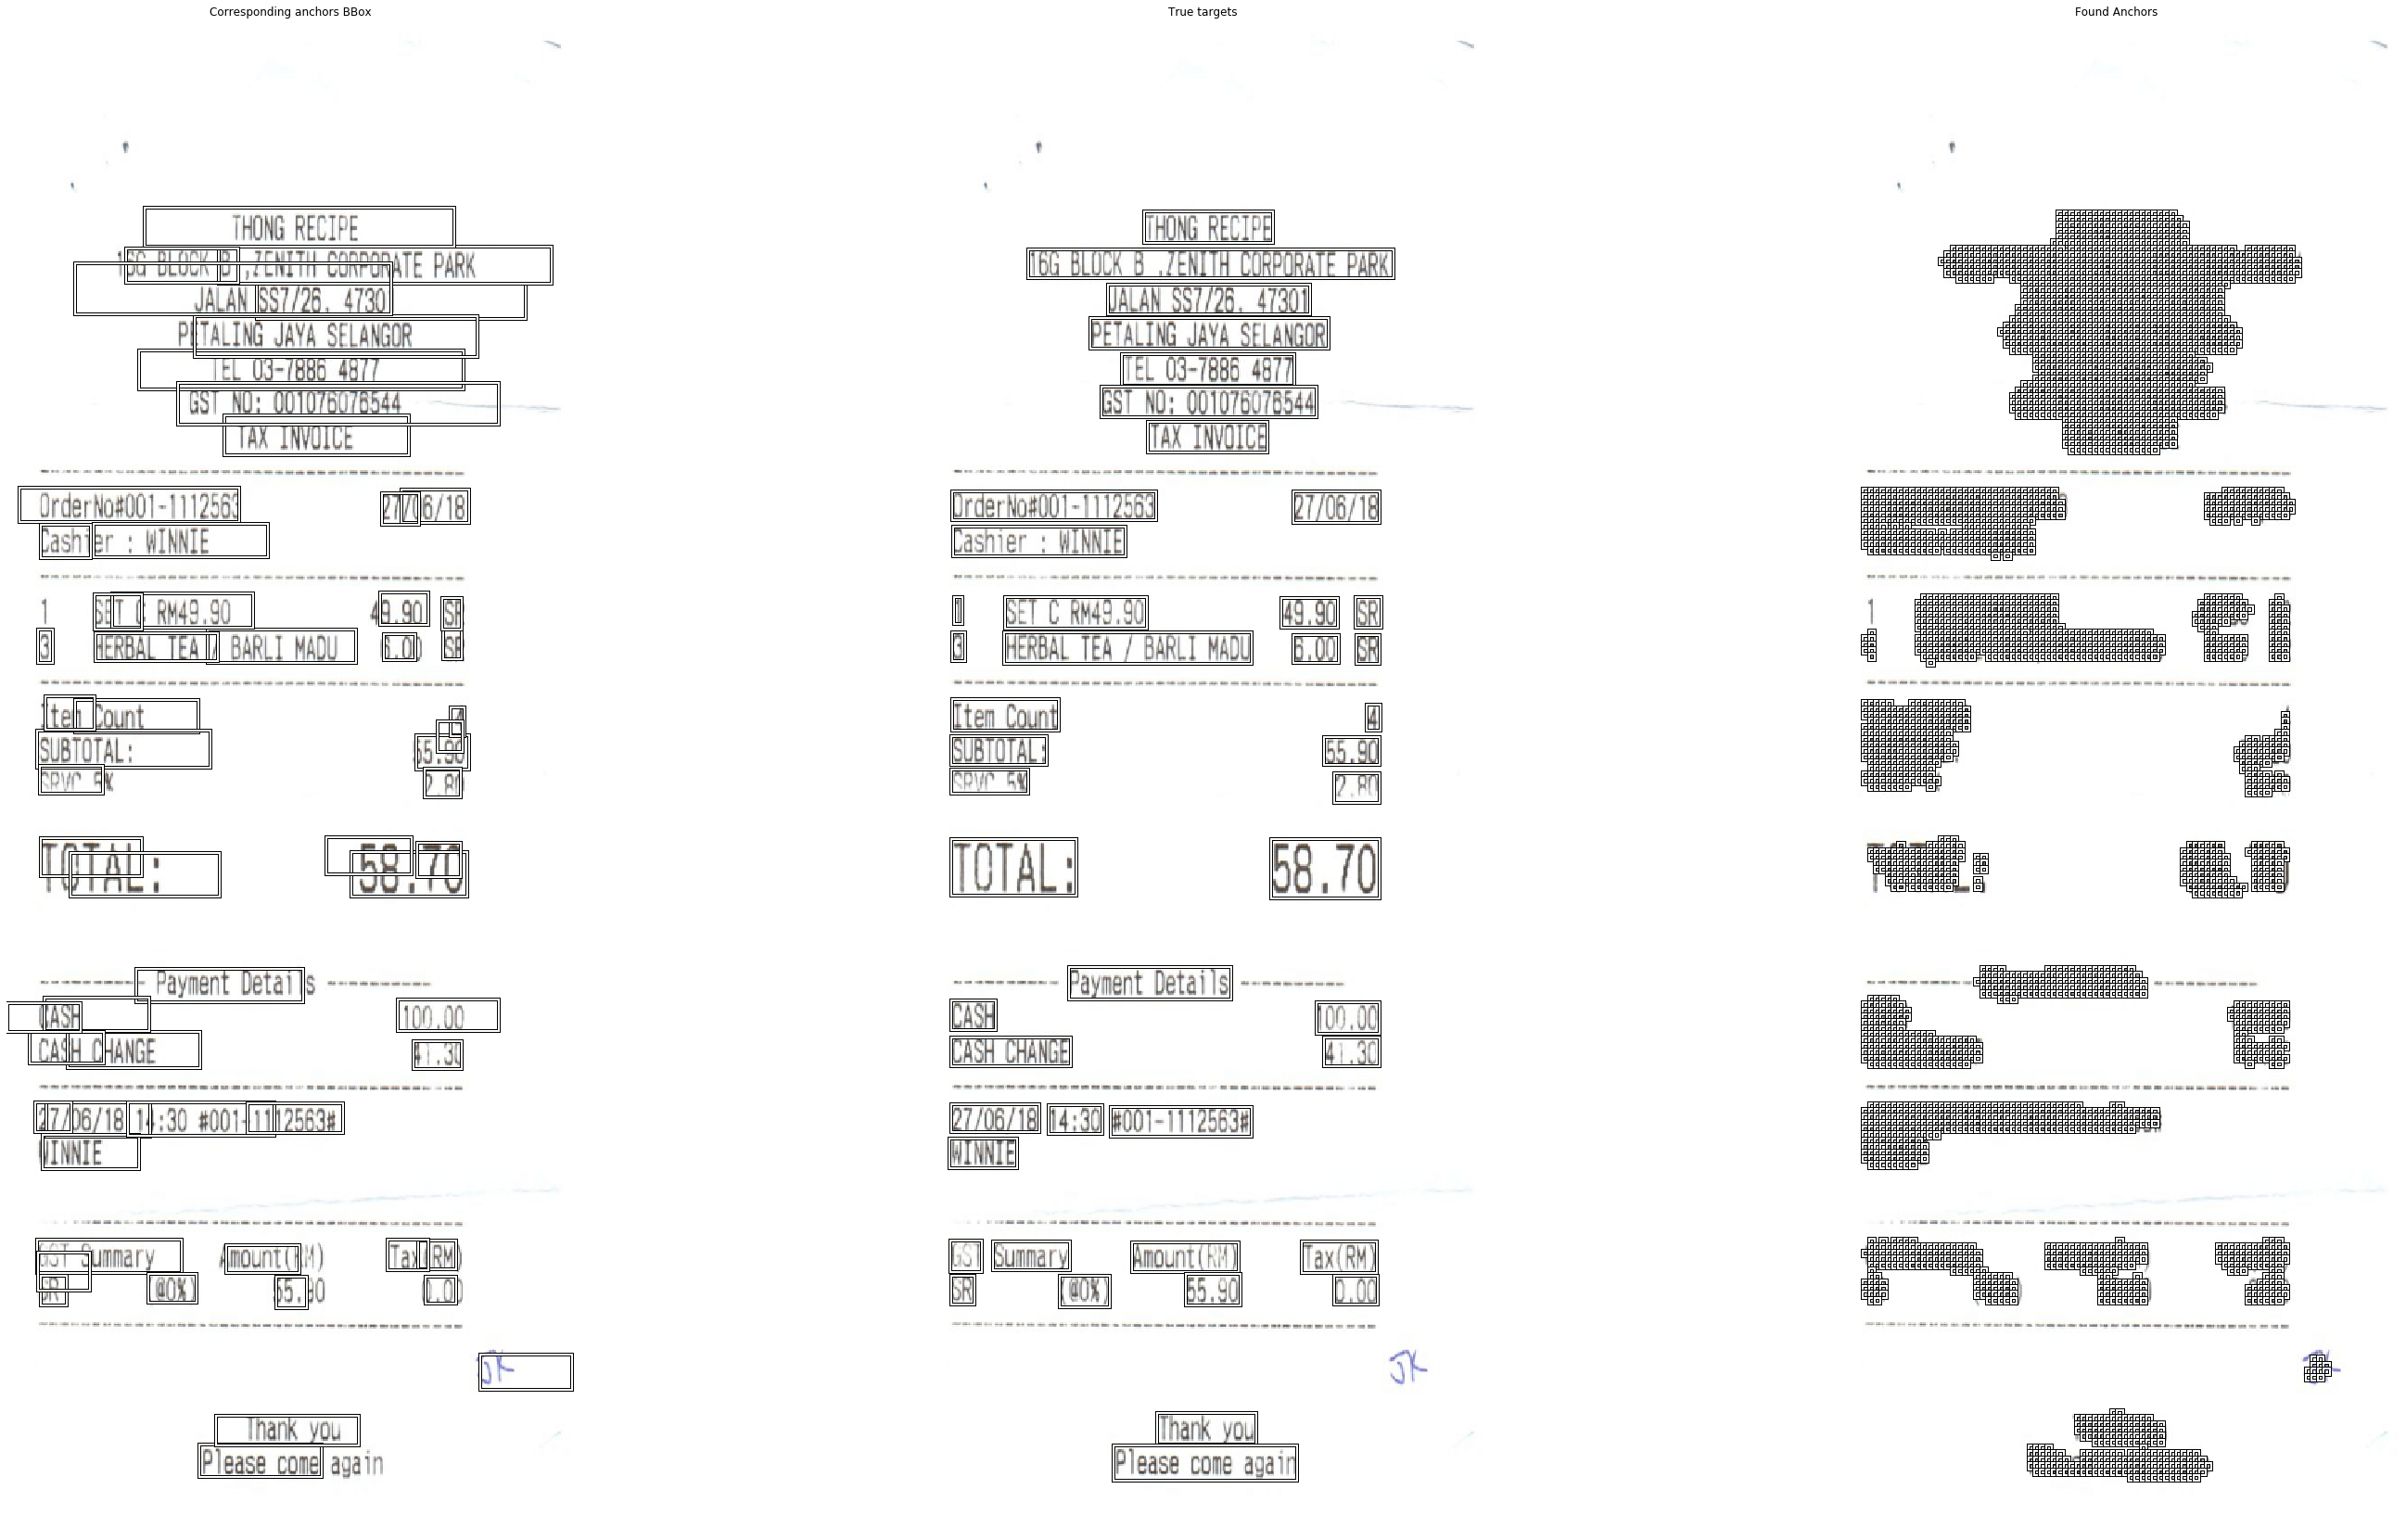

In [67]:
show_examples(learner, image_count=1, detect_thresh=0.8, show_bbox=True)

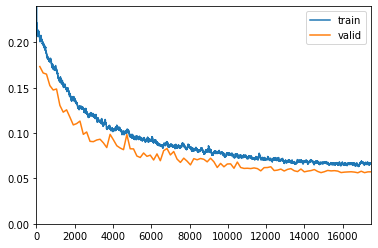

non_ignore.sum() != matches.size(0) tensor(24567, device='cuda:0') 24576


In [68]:
learner.metrics = [MSE,F1]
learner.loss_func = RetinaNetFocalLoss(anchors, class_loss_weight=0.5)
learner.fit_one_cycle(100, 1e-3)

total found bbs: tensor(4842, device='cuda:0')
after nms: 42


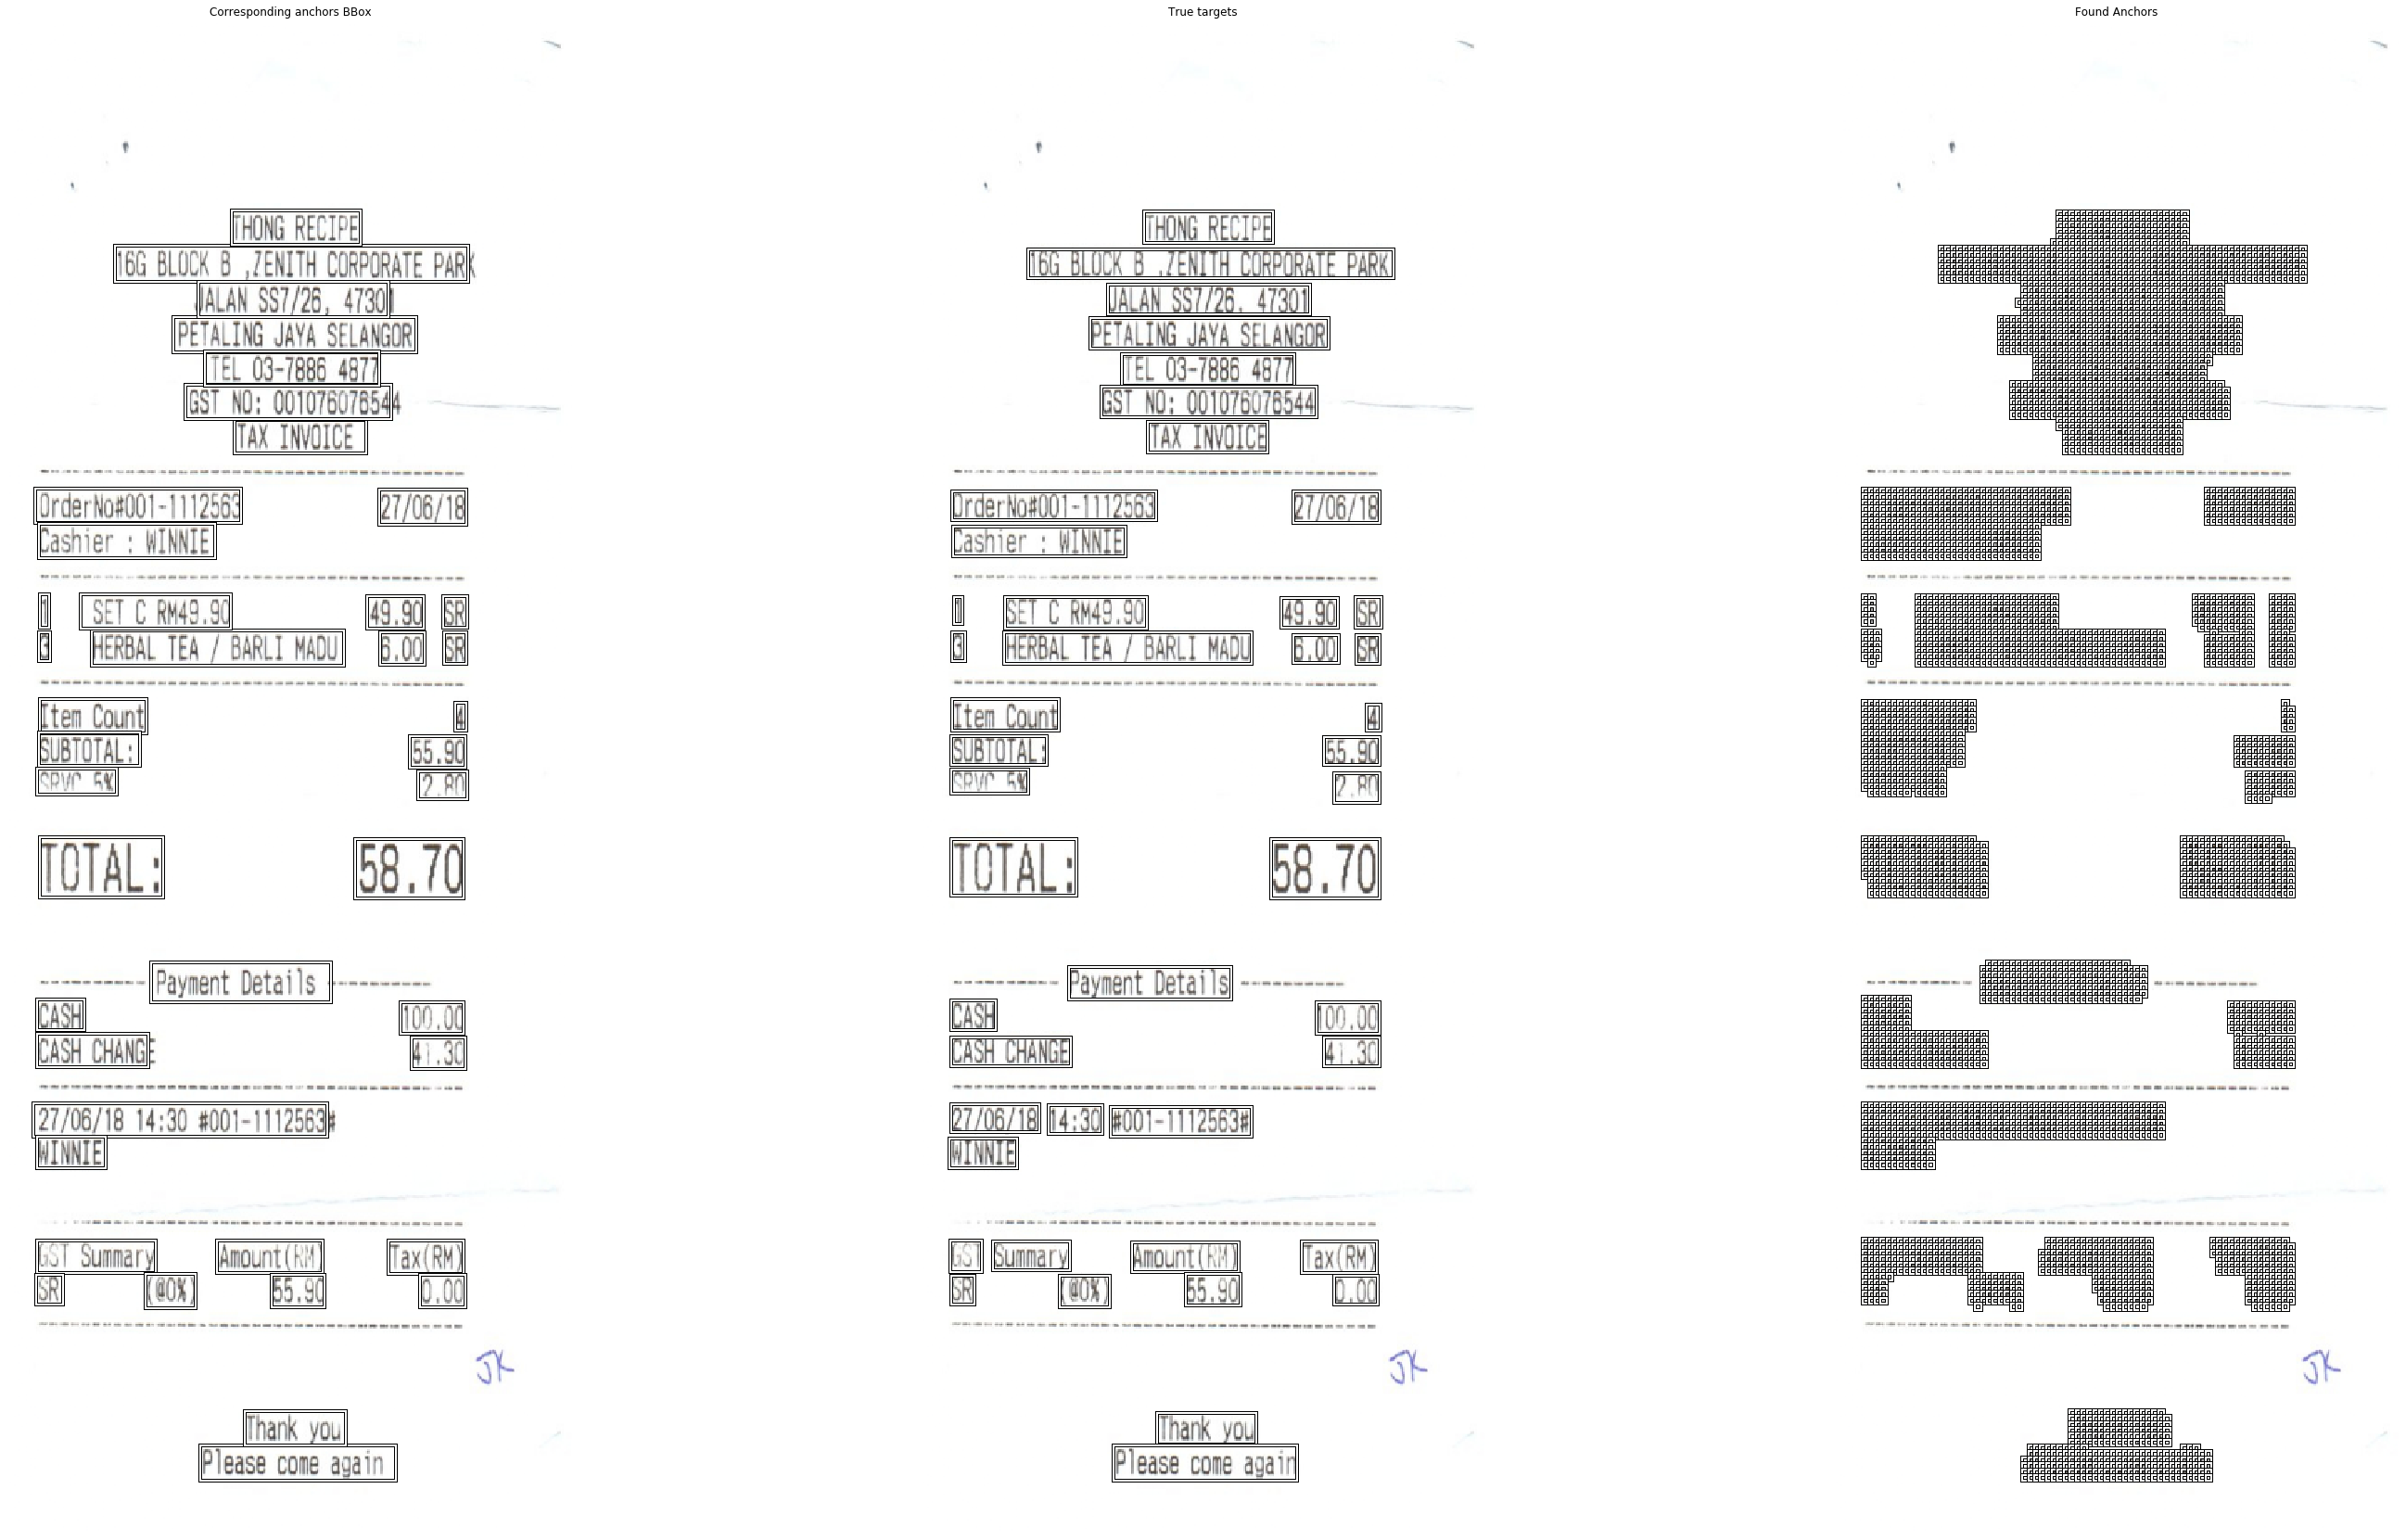

In [69]:
show_examples(learner, image_count=1, detect_thresh=0.8, show_bbox=True)

In [70]:
F1_50 = partial(F1, iou_thresh=0.5)
F1_80 = partial(F1, iou_thresh=0.8)

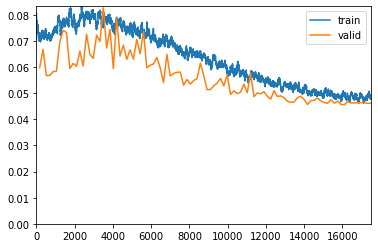

In [71]:
learner.metrics = [F1_50,F1_80]
learner.unfreeze()
learner.fit_one_cycle(100, 1e-3)

In [72]:
save_inference(learner, 'east_bbox_10x3')

total found bbs: tensor(4861, device='cuda:0')
after nms: 42


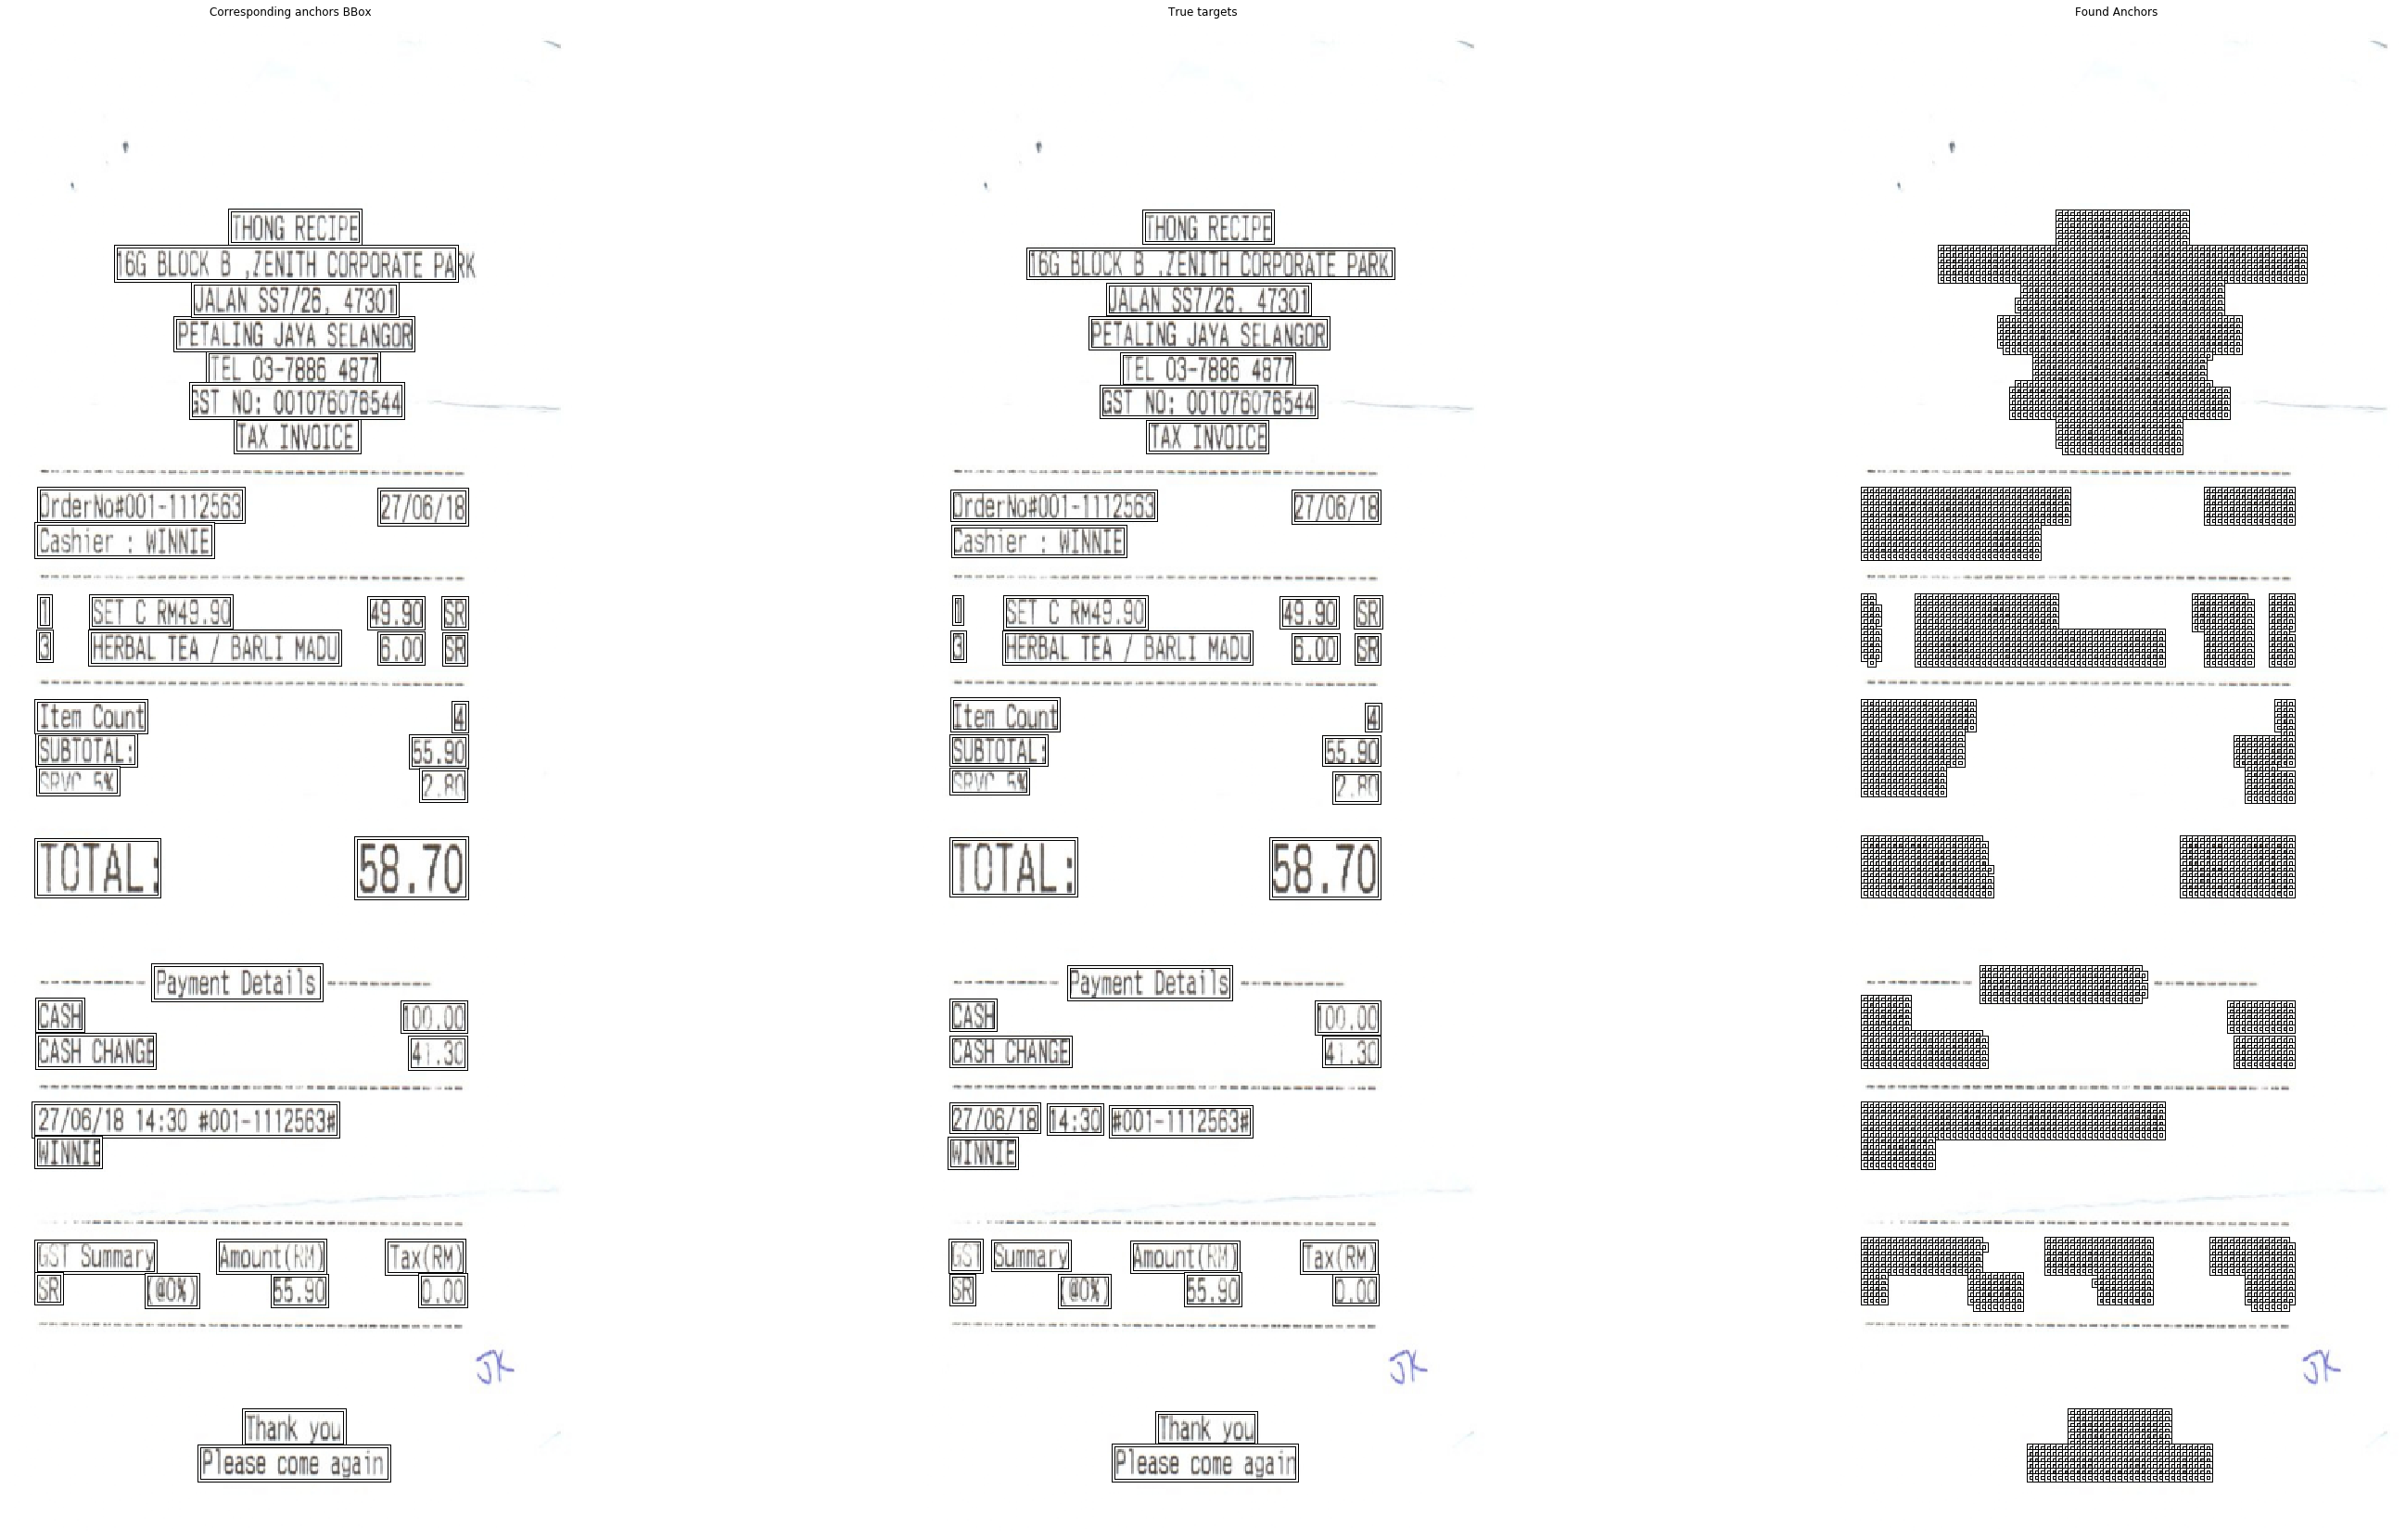

In [73]:
show_examples(learner, image_count=1, detect_thresh=0.8, show_bbox=True)

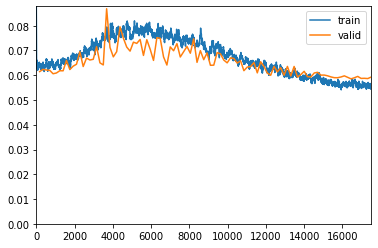

non_ignore.sum() != matches.size(0) tensor(24574, device='cuda:0') 24576


In [74]:
learner.metrics = [F1_50,F1_80]
learner.loss_func = RetinaNetFocalLoss(anchors, class_loss_weight=0.1)
learner.fit_one_cycle(100, 1e-3)

total found bbs: tensor(4818, device='cuda:0')
after nms: 42


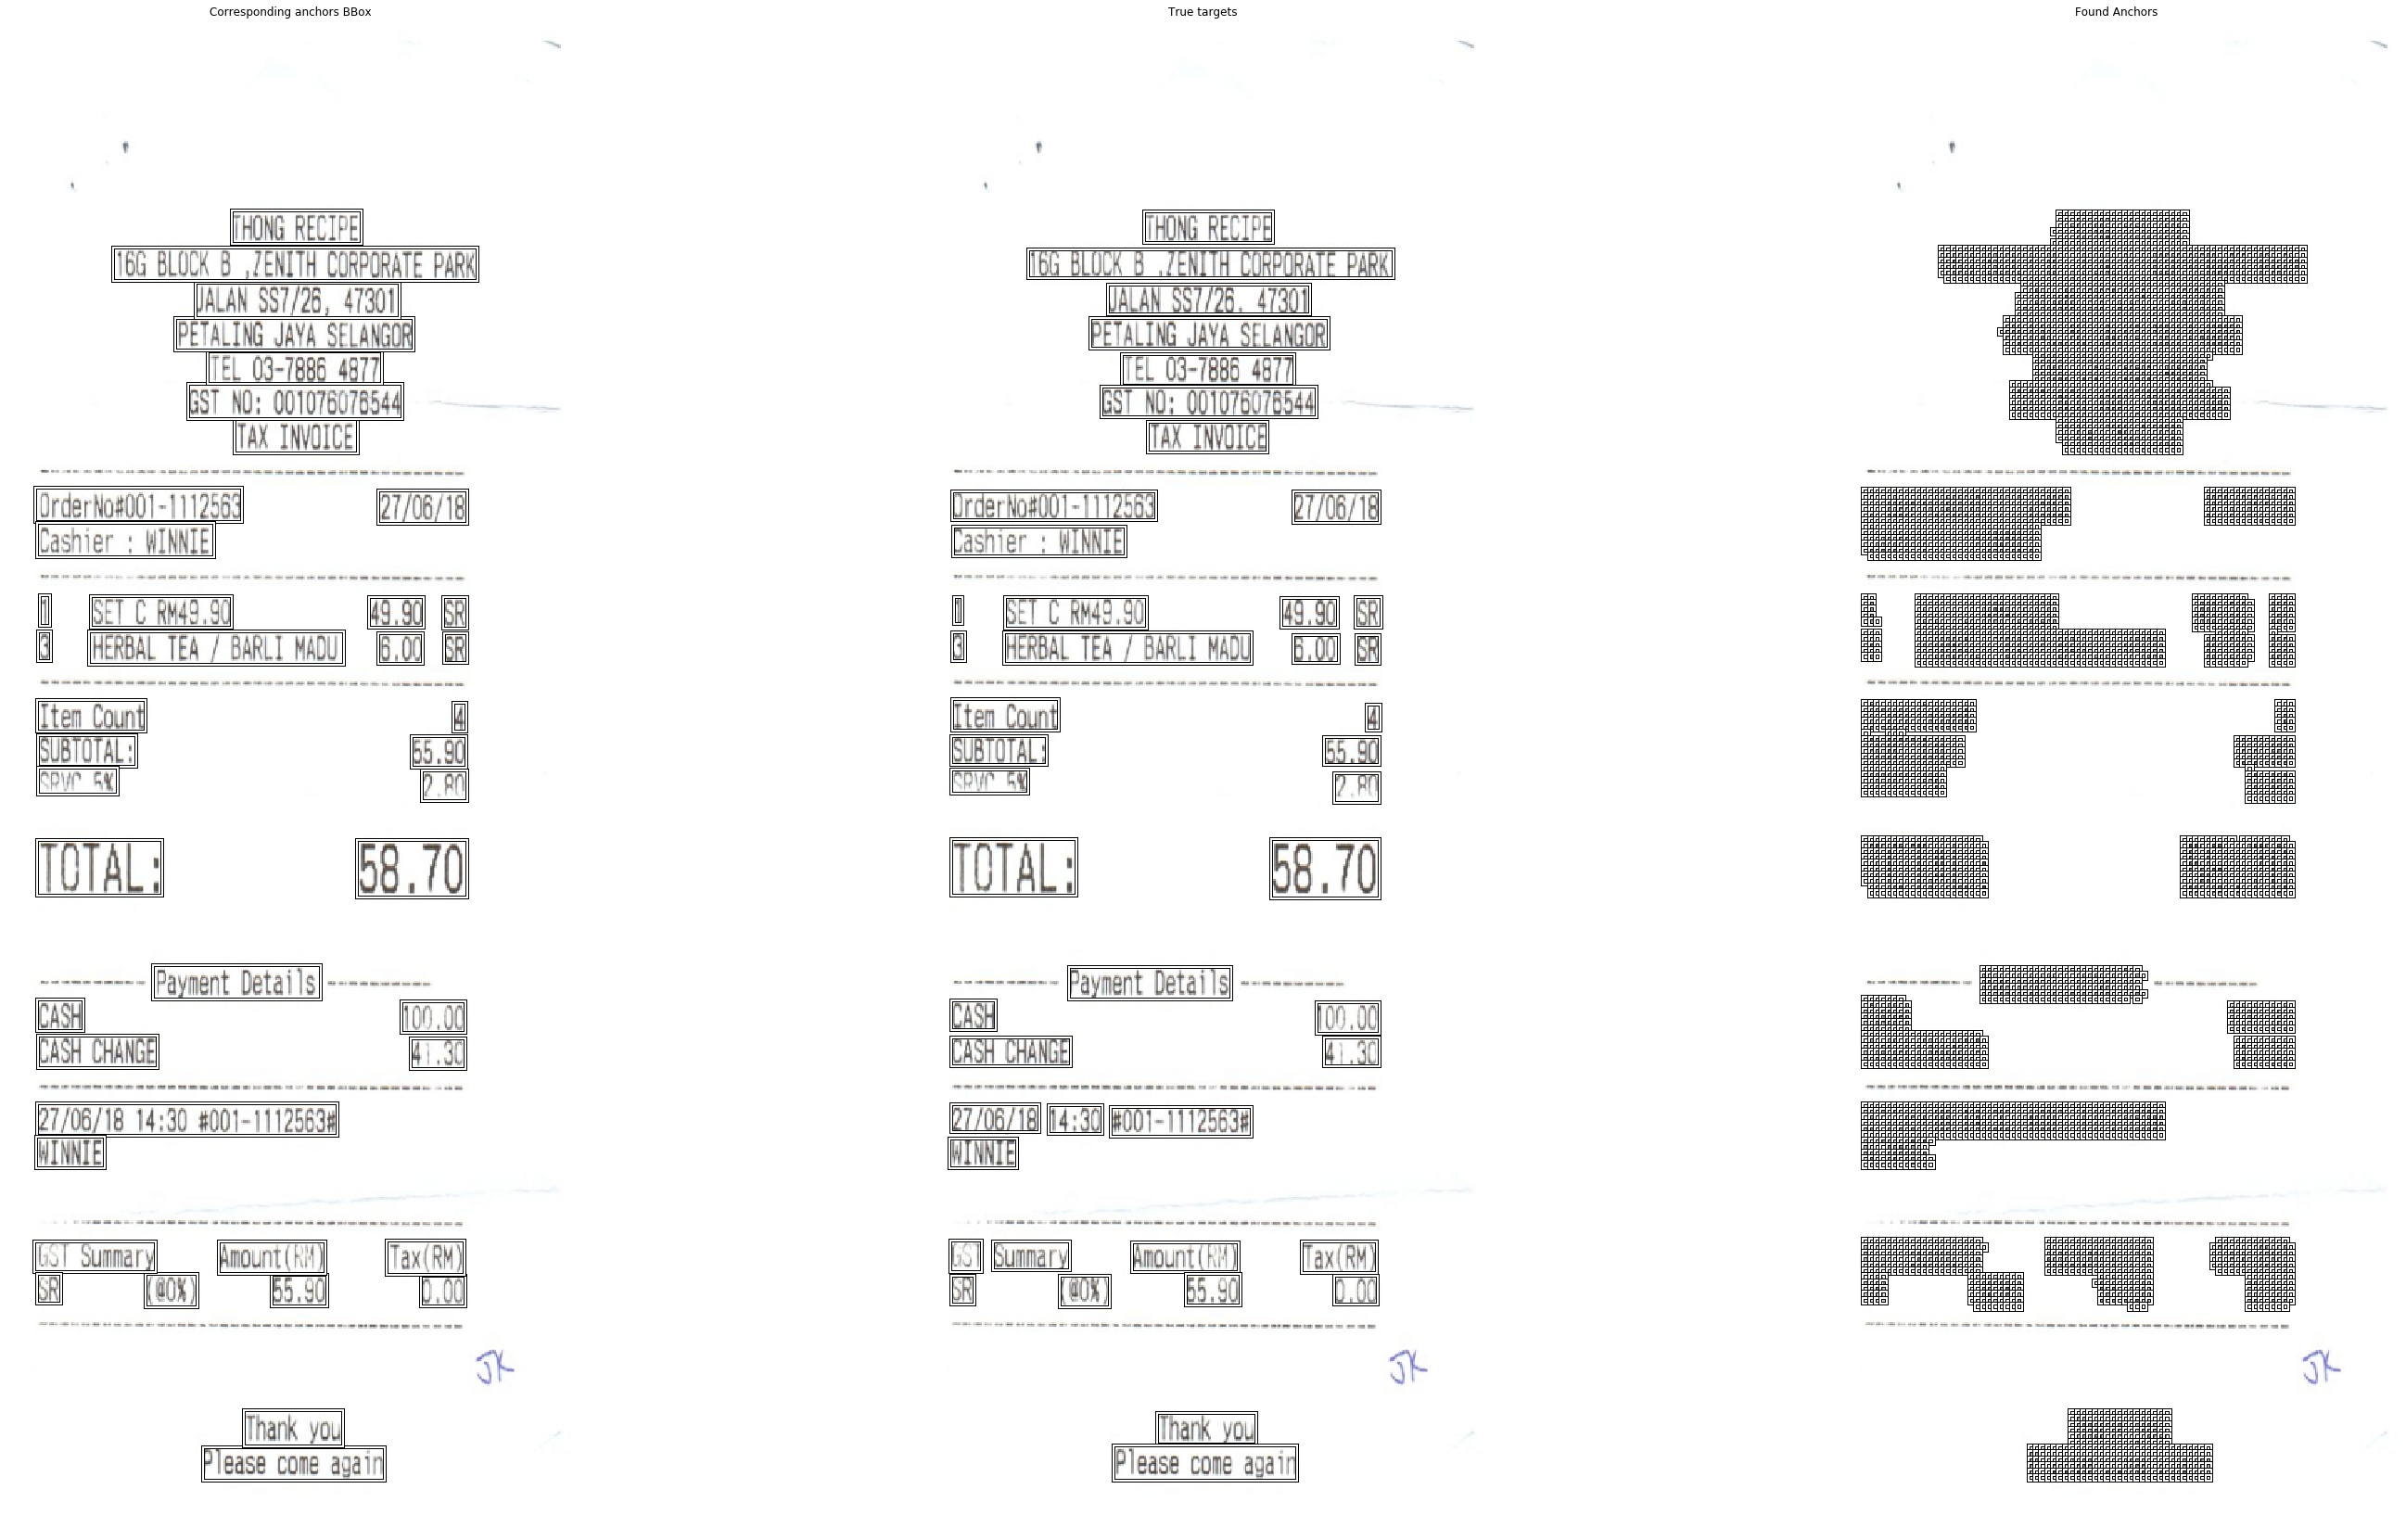

In [77]:
show_examples(learner, image_count=1, detect_thresh=0.8, show_bbox=True)

In [75]:
save_inference(learner, 'east_bbox_10x3')